In [63]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import  tqdm

#%matplotlib inline

tqdm.pandas(tqdm)


# import jellyfish
import dask.dataframe as dd

from dask.multiprocessing import get


from importlib import reload

import AddressCleanserUtils
reload(AddressCleanserUtils)
from AddressCleanserUtils import *

# import multiprocessing
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)


In [64]:
starting_time = datetime.now()

In [65]:
config_file = "config_batch"
address_file = "./address.csv.gz"
sample_size = None

import sys, getopt
opts, args = getopt.getopt(sys.argv[1:],"f:c:a:s:vq",[])

for opt, arg in opts:
    if opt == "-c":
        config_file = arg
        
    if opt == "-a":
        address_file = arg
        
    if opt == "-f":
        print("Run in jupyter ...", arg)
        AddressCleanserUtils.within_jupyter=True
        
    if opt == "-s":
        sample_size = int(arg)
        
    if opt == "-v": # Verbose
        logger.setLevel(logging.DEBUG)
        
    if opt == "-q": # quiet
        logger.setLevel(logging.WARNING)
        

Run in jupyter ... /home/vandy/.local/share/jupyter/runtime/kernel-09e6216b-6141-4cdf-a92c-7034568d0a56.json


In [68]:
if AddressCleanserUtils.within_jupyter :
    log("Running in Jupyter, using hard coded parameters")
    config_file = "config_best"
    address_file = "./best.csv.gz"
    sample_size = 1000
    AddressCleanserUtils.photon_host = "172.17.0.3:2322"
    AddressCleanserUtils.libpostal_host = "172.17.0.3:8080"
# with_dask=False
# %matplotlib inline

In [69]:
import importlib
log(f"Loading config file {config_file}")
config_module = importlib.import_module(config_file)


[2020-04-24 13:19:26,967]  Loading config file config_best


In [70]:
# Check that some required variables are present in the configuration file

field_names = ["street_field","housenbr_field","city_field","postcode_field","addr_key_field"]
#other_var_names = ["photon_host","osm_host","libpostal_host", "regex_replacements"]
other_var_names = ["regex_replacements"]
for var_name in field_names  + other_var_names:
    assert var_name in dir(config_module), var_name + " not defined in config module " + config_file


In [71]:
AddressCleanserUtils.street_field    = config_module.street_field
AddressCleanserUtils.housenbr_field  = config_module.housenbr_field
AddressCleanserUtils.city_field      = config_module.city_field
AddressCleanserUtils.postcode_field  = config_module.postcode_field

AddressCleanserUtils.addr_key_field  = config_module.addr_key_field

AddressCleanserUtils.regex_replacements = config_module.regex_replacements

AddressCleanserUtils.use_osm_parent      = use_osm_parent
AddressCleanserUtils.with_rest_libpostal = with_rest_libpostal

In [72]:
AddressCleanserUtils.pbar.register()

In [73]:
# Check that Nominatim server is running properly
try: 
    osm = get_osm("Bruxelles")
    assert osm[0]["namedetails"]["name:fr"] == "Bruxelles"
    
    vlog("OSM working properly")
    
    
except Exception as e: 
    print("OSM not up & running")
    print("OSM host: ", AddressCleanserUtils.osm_host)
    raise e


In [74]:
# In old version of Nominatim, page "details.php" could NOT return a JSON result, allowing to get place details from a place id
# In newer version, this has been added, allowing to get details about the parent of a place
# Is case "use_osm_parent" is true, check that "details.php" works correctly
if AddressCleanserUtils.use_osm_parent:
    try : 
        osm_det = get_osm_details(osm[0]["place_id"])
        assert osm_det["place_id"] == osm[0]["place_id"]

        vlog("OSM details working properly")

    except Exception as e: 
        print("OSM details not working")
        print("OSM host: ", AddressCleanserUtils.osm_host)
        raise e


In [75]:
# Check that Photon server is running properly
try: 
    ph = get_photon("Bruxelles")
    assert ph["features"][0]["properties"]["name"] == "Brussels" 
    vlog("Photon working properly")
    
    
except Exception as e: 
    print("Photon not up & running ; Start it with 'nohup java -jar photon-*.jar &'")
    print("Photon host: ", AddressCleanserUtils.photon_host)
    raise e


In [76]:
# Check that Libpostal is running properly
try: 
    lpost = parse_address("Bruxelles")
    assert lpost[0][0] == "bruxelles"
    vlog("Libpostal working properly")
except Exception as e: 
    print("Libpostal not up & running ")
    print("Libpostal: ", AddressCleanserUtils.libpostal_host)
    raise e


# Data preparation

In [77]:
# Get the addresses dataframe. Config module has to contain a "get_addresses(filename)" function, returning a dataframe, with 
# column names defined by variables (defined in config module) : street_field, housenbr_field, city_field, postcode_field , addr_key_field

log("Getting addresses")
addresses = config_module.get_addresses(address_file)
log(f"Got {addresses.shape[0]} addresses")
log(addresses)


[2020-04-24 13:19:27,188]  Getting addresses
(6251905, 5)
(1000, 5)
[2020-04-24 13:19:59,247]  Got 1000 addresses


,addr_index,street,house_number,postcode,city
1879848,1879848,Rue Nicolas Lancelot,31,6031,Charleroi
776345,776345,Rue Colonel Bourg,11,5170,Profondeville
5605514,5605514,Tervuursevest,117,3001,Leuven
5493389,5493389,Vanheylenstraat,75,1820,Steenokkerzeel
5076788,5076788,9de Liniestraat,13K,3200,Aarschot
...,...,...,...,...,...
5335848,5335848,Corneel Jaspersstraat,10,2600,Antwerpen
2419073,2419073,Stormvogelstraat,2,8380,Brugge
13335,13335,Rue Victor Allard,124,1180,Uccle
5684166,5684166,Cadixstraat,43,2000,Antwerpen


In [78]:
if sample_size :
    log(f"Keep a sample of size {sample_size}")
    addresses = addresses.sample(sample_size)


[2020-04-24 13:19:59,287]  Keep a sample of size 1000


In [79]:
# Check that all required fields are present in addresses dataframe

for field in field_names:
    assert config_module.__getattribute__(field) in addresses, f"Field {field} missing in data !"

In [80]:
# Check that the address identifier defined in config_module.addr_key_field is unique
assert addresses[addresses[config_module.addr_key_field].duplicated()].shape[0] == 0, "Key should be unique"

In [81]:
vlog("Stripping and upper casing...")
addresses = addresses.apply(lambda col: col.fillna("").astype(str).str.strip().str.upper() if col.dtype.kind=='O' else col.astype(str) )


# Main loop 

In [84]:
transformers_sequence = [ ["orig"],
                          ["regex[init]"],
                          ["nonum"],
                          ["libpostal", "regex[lpost]"], 
                          ["libpostal", "regex[lpost]", "nonum"], 
                          ["libpostal", "regex[lpost]", "photon"], 
                          ["libpostal", "regex[lpost]", "photon", "nonum"], 
                          ["photon"],
                          ["photon", "nonum"],
                          ["nostreet"]
                        ]

In [86]:
def main_loop(chunk):
    """
    Method "main_loop" processes the full cleansing sequence on a chunk of addresses : 
    - Apply a sequence of transformers (possibly empty)
    - Sent the (transformed) addresses to Nominatim
    - Parse and Check the results
    - For the addresses with no (accepted) result, try the next sequence of transformers
    """
    log(f"Chunk size: {chunk.shape[0]}")
    
    vlog(chunk)
    osm_addresses        = pd.DataFrame()
    rejected_addresses   = pd.DataFrame()
    stats = []
    
    init_chunk_size = chunk.shape[0]
    for transformers in transformers_sequence:

        vlog("--------------------------")
        vlog(f"| Transformers : { ';'.join(transformers) }")
        vlog("--------------------------")

#         display(chunk)
        osm_results, rejected, step_stats = transform_and_process(chunk, transformers, config_module.addr_key_field, 
                                                                  config_module.street_field, config_module.housenbr_field, config_module.city_field,
                                                                  config_module.postcode_field)

        osm_addresses =      osm_addresses.append(osm_results, sort=False).drop_duplicates()
        rejected_addresses = rejected_addresses.append(rejected, sort=False).drop_duplicates()

        vlog("Results: ")
        vlog(osm_results.head())
        vlog(osm_results.shape)

        vlog(f"Match rate so far: {osm_addresses.shape[0] / init_chunk_size if init_chunk_size > 0 else '(empty chunk size)'}")
             
        stats.append(step_stats)
        vlog(step_stats)

        chunk  = chunk[~chunk[config_module.addr_key_field].isin(osm_results[config_module.addr_key_field])].copy()

        ts = AddressCleanserUtils.timestats
        tot = np.sum([ts[key] for key in ts])
        if tot.total_seconds()>0:
            for key in ts: 
                vlog(f"{key:12}: {ts[key]} ({100*ts[key]/tot:.3} %)")
             
        vlog("")
        vlog("")
        vlog("####################")
        vlog("")
        vlog("")
        
    log("Chunk results: ")
    log(osm_addresses)
    log(f"Chunk match rate: {(osm_addresses.shape[0] / init_chunk_size) if init_chunk_size > 0 else '(empty chunk size)'}")
    log(pd.DataFrame(stats))
    
    return osm_addresses, rejected_addresses, stats     

In [87]:
# Compute the number of chunks
min_nb_chunks= 4

if addresses.shape[0] > max_chunk_size * min_nb_chunks:
    chunk_size = max_chunk_size
    
elif addresses.shape[0] < min_chunk_size * min_nb_chunks:
    chunk_size = min_chunk_size
else: 
    chunk_size = int(np.sqrt(max_chunk_size *min_chunk_size))
log(f"Chunk_size: {chunk_size}")


[2020-04-24 13:19:59,539]  Chunk_size: 1000


Do the main processing, with dask or simply in sequential chunks. 

Processing a chunk may require at some point a huge amount of memory. A single chunk with a few millions addresses may result in memory error ; this is why we split the main addresses dataframe is smaller chunks.


In [88]:
stats = []


if with_dask : 
    
    from dask.diagnostics import Profiler, ResourceProfiler
    
    #AddressCleanserUtils.with_dask = False
    
    # Sorting : allow to increase the probability to have duplicates within a chunk
    dd_to_process = dd.from_pandas(addresses.sort_values([config_module.postcode_field, config_module.street_field]).reset_index(drop=True), 
                                   chunksize=chunk_size)

    dask_task = dd_to_process.map_partitions(main_loop)

    with Profiler() as prof, ResourceProfiler() as rprof : 
        res =  dask_task.compute(scheduler='processes')

    log("All chunks done, gather all results...")
    
    osm_addresses      = pd.concat([chunk_osm_addresses      for (chunk_osm_addresses, _, _)      in res], sort=False)
    rejected_addresses = pd.concat([chunk_rejected_addresses for (_, chunk_rejected_addresses, _) in res], sort=False)

    for (_, _, chunk_stats) in res: 
        stats.extend(chunk_stats)

    log(f"Global match rate: { osm_addresses.shape[0]/addresses.shape[0] } ")

else: 
    #AddressCleanserUtils.with_dask = True

    osm_addresses        = pd.DataFrame()
    rejected_addresses   = pd.DataFrame()

    chunks_boundaries =  range(chunk_size, addresses.shape[0] , chunk_size)

    for chunk in tqdm(np.array_split(addresses.sort_values([config_module.postcode_field, config_module.street_field]), chunks_boundaries)):


        chunk_osm_addresses, chunk_rejected_addresses, chunk_stats = main_loop(chunk)


        osm_addresses =      osm_addresses.append(chunk_osm_addresses, sort=False).drop_duplicates()
        rejected_addresses = rejected_addresses.append(chunk_rejected_addresses, sort=False).drop_duplicates()

        log(f"Global match rate so far: {osm_addresses.shape[0]/addresses.shape[0]}")
        stats.extend(chunk_stats)


[2020-04-24 13:19:59,620]  Chunk size: 2
[2020-04-24 13:19:59,652]  Chunk results: 


,addr_index


[2020-04-24 13:19:59,662]  Chunk match rate: 0.0


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,photon,0,0,0,0,0,0,0


[                                        ] | 0% Completed |  0.0s[2020-04-24 13:19:59,864]  Chunk size: 1000
[                                        ] | 0% Completed | 21.1sPhoton reject


,addr_index,photon_full_addr,photon_order,photon_osm_type,photon_osm_value,photon_country,photon_osm_key,photon_state,photon_city,photon_postcode,...,house_number,postcode,city,fake_house_number,SIM_street,SIM_street_which,SIM_house_nbr,SIM_zip,SIM_city,reject_reason
43,46027,"RUE HAUTE, 1000 BRUXELLES",2,N,school,Belgium,amenity,Brussels-Capital,Ville de Bruxelles - Stad Brussel,1000,...,260,1000,BRUXELLES,,0.285714,photon_street,0.0,1.0,0.272727,mismatch
101,181459,"AVENUE DE L'ARAUCARIA, 1020 BRUXELLES",2,N,bicycle_rental,Belgium,amenity,Brussels-Capital,Ville de Bruxelles - Stad Brussel,1020,...,13,1020,BRUXELLES,,0.250000,photon_street,0.0,1.0,0.272727,mismatch
102,181459,"AVENUE DE L'ARAUCARIA, 1020 BRUXELLES",3,N,tram_stop,Belgium,railway,Brussels-Capital,Ville de Bruxelles - Stad Brussel,1020,...,13,1020,BRUXELLES,,0.250000,photon_street,0.0,1.0,0.272727,mismatch
103,181459,"AVENUE DE L'ARAUCARIA, 1020 BRUXELLES",4,N,tram_stop,Belgium,railway,Brussels-Capital,Ville de Bruxelles - Stad Brussel,1020,...,13,1020,BRUXELLES,,0.250000,photon_street,0.0,1.0,0.272727,mismatch
142,110295,"RUE DE BRABANT, 1030 SCHAERBEEK",2,N,police,Belgium,amenity,Brussels-Capital,Schaerbeek - Schaarbeek,1030,...,228,1030,SCHAERBEEK,,0.400000,photon_street,0.0,1.0,0.434783,mismatch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081,992733,"RUE DU PETIT MARAIS, 7011 MONS",9,N,guest_house,Belgium,tourism,Wallonia,Mons,7012,...,33,7011,MONS,,1.000000,photon_street,0.0,0.5,1.000000,tail
3073,992733,"RUE DU PETIT MARAIS, 7011 MONS",1,W,tertiary,Belgium,highway,Wallonia,Mons,7011,...,33,7011,MONS,,0.666667,photon_street,0.0,1.0,1.000000,tail
3074,992733,"RUE DU PETIT MARAIS, 7011 MONS",2,W,residential,Belgium,highway,Wallonia,Mons,7012,...,33,7011,MONS,,0.666667,photon_street,0.0,0.5,1.000000,tail
3075,992733,"RUE DU PETIT MARAIS, 7011 MONS",3,W,residential,Belgium,highway,Wallonia,Mons,7012,...,33,7011,MONS,,0.666667,photon_street,0.0,0.5,1.000000,tail


[                                        ] | 0% Completed | 47.2s[2020-04-24 13:20:47,001]  Chunk results: 


,osm_addr_in,addr_index,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
0,"Rue Monsville, 120, 7390 Quaregnon",1011765,631231,50.437436,3.8648648,"Rue Monsville, Quaregnon, Mons, Hainaut, Wallo...",Rue Monsville,26,highway,tertiary,addr_out_street,1.0,Rue Monsville,Quaregnon,None,België / Belgique / Belgien,7390,,NaN,photon
1,"Rue de Genly, 9, 6110 Montigny-le-Tilleul",1034611,668184,50.3811754,4.3784254,"Rue de Genly, Bomerée, Montigny-le-Tilleul, Ch...",Rue de Genly,26,highway,residential,addr_out_street,1.0,Rue de Genly,Montigny-le-Tilleul,None,België / Belgique / Belgien,6110,Bomerée,NaN,photon
3,"Rue du Plat Rié, 286, 7390 Quaregnon",1055589,1696459,50.4270599,3.856548,"Rue du Plat Rié, Quaregnon, Mons, Hainaut, Wal...",Rue du Plat Rié,26,highway,residential,addr_out_street,1.0,Rue du Plat Rié,Quaregnon,None,België / Belgique / Belgien,7390,,NaN,photon
4,"Avenue des Éperviers - Sperwerlaan, 67, 1150 W...",110087,1380953,50.8259057,4.41440350920779,"67, Avenue des Éperviers - Sperwerlaan, Woluwe...",,30,building,yes,addr_out_street,1.0,Avenue des Éperviers - Sperwerlaan,Woluwe-Saint-Pierre - Sint-Pieters-Woluwe,67,België / Belgique / Belgien,1150,,NaN,photon
5,"Rue de Brabant - Brabantstraat, 228, 1030 Scha...",110295,1214203,50.86246435,4.36549189198215,"228, Rue de Brabant - Brabantstraat, Schaerbee...",,30,building,yes,addr_out_street,1.0,Rue de Brabant - Brabantstraat,Schaerbeek - Schaarbeek,228,België / Belgique / Belgien,1030,,NaN,photon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,"Rue du Petit Marais, 33, 7012 Mons",992733,1441715,50.4710045,3.8826848,"Rue du Petit Marais, Saint-Ghislain, Mons, Hai...",Rue du Petit Marais,26,highway,unclassified,addr_out_street,1.0,Rue du Petit Marais,Saint-Ghislain,None,België / Belgique / Belgien,7012,,NaN,photon
396,"Rue L. Dewolf, 20, 7010 Mons",995965,618413,50.4900829,3.9666851,"Rue L. Dewolf, Mons, Hainaut, Wallonie, 7010, ...",Rue L. Dewolf,26,highway,residential,addr_out_street,1.0,Rue L. Dewolf,Mons,None,België / Belgique / Belgien,7010,,NaN,photon
12,"Universiteitsplein, 1, 2610 Antwerp",4715192,1104080,51.1621501,4.40351190289472,"D, 1, Universiteitsplein, Wilrijk, Antwerpen, ...",,30,building,university,addr_out_street,1.0,Universiteitsplein,Wilrijk,1,België / Belgique / Belgien,2610,D,True,photon
16,"Krijgslaan, 98, 9000 Ghent",4831689,2293442,51.0335115,3.72040594813028,"98-98L, Krijgslaan, Sint-Pieters-Aalst, Gent, ...",,30,building,house,addr_out_street,1.0,Krijgslaan,Gent,98-98L,België / Belgique / Belgien,9000,Sint-Pieters-Aalst,True,photon


[2020-04-24 13:20:47,085]  Chunk match rate: 0.302


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,photon,1000,303,302,3,95,64,1


[########################################] | 100% Completed | 48.2s
[########################################] | 100% Completed | 48.2s
[2020-04-24 13:20:48,891]  All chunks done, gather all results...
[2020-04-24 13:20:48,914]  Global match rate: 0.302 


In [62]:
# inclusion_test("NEU", "NEUCHATEAU")

In [63]:
addresses

,addr_index,street,house_number,postcode,city
36487,36487,RUE DES RENONCULES,35,1170,WATERMAEL-BOITSFORT
5230426,5230426,PRINSES STEFANIEPLEIN,9,8400,OOSTENDE
2332696,2332696,WAYEZSTRAAT,31,1070,ANDERLECHT
4262388,4262388,STORMESTRAAT,116,8790,WAREGEM
3110684,3110684,BARTHELSSTRAAT,44,8310,BRUGGE
...,...,...,...,...,...
2542890,2542890,TURNHOUTSEBAAN,454,2110,WIJNEGEM
2619590,2619590,VOORSTRAAT,104,9970,KAPRIJKE
2515527,2515527,BERTELSBROEKSTRAAT,20,2235,HULSHOUT
3854426,3854426,DENDERHOUTEMBAAN,205,9400,NINOVE


In [64]:
# get_osm("6840 NEUFCHÂTEAU")

In [65]:
if with_dask:
    from dask.diagnostics import visualize
    from bokeh.io import output_notebook, output_file
    output_file("dask_stats.html")
    # output_notebook()
    visualize([prof, rprof])

[2020-04-24 06:24:34,599]  Session output file 'profile.html' already exists, will be overwritten.


In [66]:
# osm_addresses.SIM_street_which.value_counts() /osm_addresses.shape[0] #.plot.pie()

# Rejected addresses

Give some statistics about rejected adresses. 
"rejected_addresses" contains two types of rejected addresses : 
- rejected_addresses["reject_reason"] == "mismatch" : by comparing field by field input address and output address, this addresses has been rejected
- rejected_addresses["reject_reason"] == "tail" : when OSM returns several results, only one is kept in "osm_addresses", all the others are put in rejected_addresses

Note that an addresse may have been rejected at a specific step (for a giver sequence of transformer), but not at another one.
"rejected_addresses" may then contain a lot of addresses for which a result has been accepted further on.

"rejected_addresses_final" contains the only addresses for which all results have been rejected.


In [67]:
rejected_addresses_final =  rejected_addresses[rejected_addresses["reject_reason"] == "mismatch"]

rejected_addresses_final =  rejected_addresses_final[~rejected_addresses_final[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])]

# Needed with check_with_transformed = True (but doesn't hurt if not)
rejected_addresses_final = rejected_addresses_final.drop([config_module.street_field,
                                                          config_module.housenbr_field,
                                                          config_module.postcode_field,
                                                          config_module.city_field], axis=1
                                                        )

# print(rejected_addresses.keys())
# print(osm_addresses.keys())
# print(rejected_addresses.keys() & osm_addresses.keys())

rejected_addresses_final  = rejected_addresses_final.merge(addresses).sort_values(["SIM_street", config_module.addr_key_field])[["method", 
    config_module.addr_key_field, "osm_addr_in", 
    config_module.street_field, config_module.housenbr_field, config_module.postcode_field, config_module.city_field, 
    "addr_out_street", "addr_out_city", "addr_out_number", "addr_out_postcode", "addr_out_other", "SIM_street", "SIM_zip"]].drop_duplicates()
log("Rejected addresses: ")
log(rejected_addresses_final)

[2020-04-24 06:24:35,260]  Rejected addresses: 


,method,addr_index,osm_addr_in,street,house_number,postcode,city,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


In [68]:
log(f"Number of unique rejected addresses: {rejected_addresses_final[config_module.addr_key_field].nunique()}")

[2020-04-24 06:24:35,310]  Number of unique rejected addresses: 0


In [69]:
log(f"Number of unique city-streets in rejected addresses: {rejected_addresses_final[[config_module.postcode_field, config_module.street_field]].drop_duplicates().shape[0]}")


[2020-04-24 06:24:35,328]  Number of unique city-streets in rejected addresses: 0


In [70]:
rejected_addresses_final[rejected_addresses_final.addr_out_street.isnull()]

,method,addr_index,osm_addr_in,street,house_number,postcode,city,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


In [71]:
rejected_addresses_final[rejected_addresses_final.addr_out_street.notnull()]#.drop(["method"], axis=1).drop_duplicates()

,method,addr_index,osm_addr_in,street,house_number,postcode,city,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


In [72]:
# Swap street - city
log("Rejected addresses, but where it might have a swap between street and city")
str_cmp= street_compare(rejected_addresses_final[config_module.street_field], rejected_addresses_final.addr_out_city)
x= rejected_addresses_final[(str_cmp>0.5) & (rejected_addresses_final.addr_out_street.isnull()) & (rejected_addresses_final.SIM_zip >= 0.1)].drop_duplicates(subset=config_module.addr_key_field)
log(x)
log(f"Number of unique addresses: {x[config_module.addr_key_field].nunique()}")

[2020-04-24 06:24:35,452]  Rejected addresses, but where it might have a swap between street and city


,method,addr_index,osm_addr_in,street,house_number,postcode,city,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


[2020-04-24 06:24:35,491]  Number of unique addresses: 0


In [73]:
# Other mismatches
rejected_addresses_final[(str_cmp<=0.5) | (rejected_addresses_final.addr_out_street.notnull()) | (rejected_addresses_final.SIM_zip < 0.1)].drop_duplicates(subset=config_module.addr_key_field)

,method,addr_index,osm_addr_in,street,house_number,postcode,city,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


# No match

In [74]:
log("Addresses with no match (but some matches where rejected)")
log(addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])])


[2020-04-24 06:24:35,570]  Addresses with no match (but some matches where rejected)


,addr_index,street,house_number,postcode,city


In [75]:
rejected_addresses

,index,osm_addr_in,addr_index,osm_order,place_id,lat,lon,display_name,namedetails,place_rank,...,SIM_zip,SIM_city,reject_reason,method,addr_bus_stop,addr_caravan_site,addr_information,addr_station,addr_junction,addr_parking
166,166.0,"LAAN I, 100, 1770 LIEDEKERKE",3005042,0.0,755841.0,50.8700439,4.0984367,"Laan-1, Liedekerke, Halle-Vilvoorde, Vlaams-Br...",Laan-1,26.0,...,1.0,1.000000,mismatch,orig,NaN,NaN,NaN,NaN,NaN,NaN
712,712.0,"LAVAUX, 23, 4980 TROIS-PONTS",1759467,0.0,117765.0,50.3416652,5.9219164,"La Vau, Verviers, Liège, Wallonie, 6698, Belgi...",,19.0,...,0.0,0.181818,mismatch,orig,NaN,NaN,NaN,NaN,NaN,NaN
832,832.0,"OUR, 33, 6852 PALISEUL",615113,0.0,114659.0,49.9601328,5.1238515,"Our, Neufchâteau, Luxembourg, Wallonie, 6852, ...",,19.0,...,1.0,0.125000,mismatch,orig,NaN,NaN,NaN,NaN,NaN,NaN
841,841.0,"MOUSNY, 107, 6983 LA ROCHE-EN-ARDENNE",580771,2.0,114232.0,50.1032254,5.6131199,"Mousny, Marche-en-Famenne, Luxembourg, Walloni...",,19.0,...,1.0,0.105263,mismatch,orig,NaN,NaN,NaN,NaN,NaN,NaN
845,845.0,"HIVES, 18, 6984 LA ROCHE-EN-ARDENNE",597602,3.0,117495.0,50.1506704,5.5783344,"Hives, Marche-en-Famenne, Luxembourg, Wallonie...",,19.0,...,0.5,0.105263,mismatch,orig,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,9.0,3570 ALKEN,5065019,3.0,348437.0,50.8748072,5.305864,"Alken, 5, Hoogdorpsstraat, Alken, Tongeren, Li...",,30.0,...,1.0,1.000000,tail,nostreet,NaN,NaN,Alken,None,None,None
18,18.0,7170 MANAGE,875928,1.0,100044.0,50.4978483,4.222161,"Manage, Autoroute de Wallonie, Petit-Bois-d'Ha...",19 - Manage,30.0,...,1.0,1.000000,tail,nostreet,NaN,NaN,None,None,Manage,None
19,19.0,7170 MANAGE,875928,2.0,151197.0,50.4986945,4.2389407,"Manage, Autoroute de Wallonie, Cité de Scailmo...",19 - Manage,30.0,...,1.0,1.000000,tail,nostreet,NaN,NaN,None,None,Manage,None
20,20.0,7170 MANAGE,875928,3.0,431997.0,50.5060139,4.2345395,"Manage, Place de la Gare, Cité de Scailmont, M...",,30.0,...,1.0,1.000000,tail,nostreet,NaN,NaN,None,Manage,None,None


In [76]:
log("Addresses with no match at all")
no_match = addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])]
log(no_match)

[2020-04-24 06:24:35,772]  Addresses with no match at all


,addr_index,street,house_number,postcode,city


In [77]:
log(f"Number of unique city-streets in no match addresses: {no_match[[config_module.postcode_field, config_module.street_field]].drop_duplicates().shape[0]}")


[2020-04-24 06:24:35,822]  Number of unique city-streets in no match addresses: 0


In [78]:
log("Main cities in no match addresses: ")
log(no_match[config_module.city_field].value_counts().head(10))

[2020-04-24 06:24:35,849]  Main cities in no match addresses: 


Series([], Name: city, dtype: int64)

In [79]:
log("Main streets in no match addresses: ")
log(no_match[config_module.street_field].value_counts().head(10))

[2020-04-24 06:24:35,874]  Main streets in no match addresses: 


Series([], Name: street, dtype: int64)

# Extra house number

In many situation, OSM does not return a correct house number : 
- Either because the building is not known by OSM. In this case, house number is empty in result
- Or because house number in input also contains information such as box, level...

We then consider that house number is not reliable enough and compute our own house number field, named "extra_house_nbr"

In [80]:
log("Add extra house number")
osm_addresses = add_extra_house_number(osm_addresses, addresses, street_field=config_module.street_field, housenbr_field=config_module.housenbr_field)

[2020-04-24 06:24:35,909]  Add extra house number


In [81]:
# osm_addresses.drop("extra_house_nbr", axis=1, inplace=True)

In [82]:
ex_hs_nb = osm_addresses[[config_module.addr_key_field, "osm_addr_in", "extra_house_nbr", "addr_out_number"]].replace("", np.NaN)

In [83]:
log("Add new information: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.isnull() & ex_hs_nb.extra_house_nbr.notnull()])

[2020-04-24 06:24:36,108]  Add new information: 


,addr_index,osm_addr_in,extra_house_nbr,addr_out_number
0,1008254,"RUE DES COMBATTANTS, 49, 7780 COMINES-WARNETON",49,None
1,1018317,"SENTIER CAVENAILE, 10, 7000 MONS",10,None
2,1021149,"RUE GRANDE, 264, 7020 MONS",264,None
3,1028351,"RUE DE SCRAWELLE, 39, 7180 SENEFFE",39,None
4,1033551,"CHAUSSÉE DE NIVELLES, 110, 7181 SENEFFE",110,None
...,...,...,...,...
995,5010520,9860 OOSTERZELE,4,None
996,5057282,9120 BEVEREN,11,None
997,5065019,3570 ALKEN,7,None
998,5076788,3200 AARSCHOT,13K,None


In [84]:
log("No number at all: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.isnull() & ex_hs_nb.extra_house_nbr.isnull()])

[2020-04-24 06:24:36,170]  No number at all: 


,addr_index,osm_addr_in,extra_house_nbr,addr_out_number


In [85]:
log("Agreed: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number == ex_hs_nb.extra_house_nbr)])

[2020-04-24 06:24:36,200]  Agreed: 


,addr_index,osm_addr_in,extra_house_nbr,addr_out_number
13,110087,"AVENUE DES EPERVIERS, 67, 1150 WOLUWE-SAINT-PI...",67,67
14,110295,"RUE DE BRABANT, 228, 1030 SCHAERBEEK",228,228
16,111071,"RUE DE L'AÉRODROME, 22, 1130 BRUXELLES",22,22
18,111424,"RUE EDITH CAVELL, 147, 1180 UCCLE",147,147
24,113719,"RUE MASUI, 99, 1000 BRUXELLES",99,99
...,...,...,...,...
929,97373,"AVENUE ORBAN, 172, 1150 WOLUWE-SAINT-PIERRE",172,172
968,1944077,"Place Vielle Montagne, 2, 4020 Liège",2,2
970,2410216,"Kannunink Duclosstraat, 20, 8000 Bruges",20,20
977,776345,"Rue du Colonel Bourg, 11, 5170 Profondeville",11,11


In [86]:
log("Disagreed: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number != ex_hs_nb.extra_house_nbr)])

[2020-04-24 06:24:36,259]  Disagreed: 


,addr_index,osm_addr_in,extra_house_nbr,addr_out_number
203,2184041,"HUNDERENVELD, 151, 1082 SINT-AGATHA-BERCHEM",151,151-157
329,2955024,"LUTLOMMEL, 36, 3920 LOMMEL",36,36-36B
386,3281929,"LANE, 50, 8000 BRUGGE",50,50-52
393,3305036,"BROEKSTRAAT, 58A, 9220 HAMME",58A,58a
447,3644754,"HEERNISLAAN, 99, 9000 GENT",99,99-99C
453,3674141,"LEERNSESTEENWEG, 8, 9800 DEINZE",8,8-8A
576,4466430,"PATIJNTJESTRAAT, 190, 9000 GENT",190,190-208
593,4551957,"EREMBODEGEM-DORP, 117, 9320 AALST",117,115;117
609,4665040,"PIETER VANHOUDTSTRAAT, 38, 3582 BERINGEN",38,36-38
616,4755179,"ACHIEL DENYSSTRAAT, 9, 8800 ROESELARE",9,9-10


In [87]:
log("Error: ") # There were no number in input, but OSM found one
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.isnull()])

[2020-04-24 06:24:36,343]  Error: 


,addr_index,osm_addr_in,extra_house_nbr,addr_out_number


In [88]:
extra_address_stats = {
    "New information" : (ex_hs_nb.addr_out_number.isnull()  & ex_hs_nb.extra_house_nbr.notnull()).sum(),
    "No number at all": (ex_hs_nb.addr_out_number.isnull()  & ex_hs_nb.extra_house_nbr.isnull() ).sum(),
    "Agree"  :          (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number == ex_hs_nb.extra_house_nbr)).sum(),
    "Disagree":         (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number != ex_hs_nb.extra_house_nbr)).sum(),
    "Error" :           (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.isnull()).sum()
    
}
extra_address_stats = pd.DataFrame(extra_address_stats, index=["Count"]).T
log(extra_address_stats)

,Count
New information,567
No number at all,0
Agree,391
Disagree,42
Error,0


In [89]:
# extra_address_stats.Count.plot.pie(label="",  autopct='%1.1f%%')

In [90]:
assert extra_address_stats.Count.sum() == osm_addresses.shape[0]

# Some stats

In [91]:
_stats = pd.DataFrame(stats)[["method","todo", "sent", "match", "match_26", "reject_rec", "reject_addr", "reject_mism"]]
_stats = _stats.reset_index().groupby("method").sum().reset_index().sort_values("index").drop("index", axis=1)

In [92]:
assert osm_addresses.shape[0] == _stats["match"].sum()

In [93]:
log(f"Global match rate : {osm_addresses.shape[0]/addresses.shape[0]}")

[2020-04-24 06:24:36,534]  Global match rate : 1.0


In [94]:
rejected_count = rejected_addresses[~rejected_addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])][config_module.addr_key_field].nunique()
rejected_count

nomatch_count = addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])].shape[0]

rejected_count, nomatch_count

(0, 0)

In [95]:
#rejected_addresses[~rejected_addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])]


In [96]:
# osm_addresses[osm_addresses.EntityNumber == "2.227.707.047"]

In [97]:
missing_address_count = addresses.shape[0] - osm_addresses.shape[0]

assert rejected_count + nomatch_count == missing_address_count

# print("Missing : ", missing_address_count)

In [98]:
_stats = _stats.append(pd.DataFrame([{"method": "reject", "todo": rejected_count, "match": rejected_count},
                              {"method": "nomatch", "todo": nomatch_count, "match": nomatch_count},
                             ]), sort=False)

In [99]:
_stats["match rate"] = _stats["match"]/_stats["sent"]
_stats["glob match rate"] = _stats["match"]/addresses.shape[0]

log(_stats[_stats.match > 0])#.sort_values("match", ascending=False)

,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism,match rate,glob match rate
6,orig,1000,1000.0,943,10.0,360.0,225.0,5.0,0.943000,0.943
4,nonum,57,57.0,16,0.0,20.0,8.0,1.0,0.280702,0.016
2,libpostal+regex[lpost]+photon,41,22.0,22,0.0,9.0,7.0,0.0,1.000000,0.022
7,photon,19,2.0,2,0.0,3.0,2.0,0.0,1.000000,0.002
5,nostreet,17,17.0,17,0.0,19.0,9.0,0.0,1.000000,0.017


In [100]:
#

In [101]:
if AddressCleanserUtils.within_jupyter:
    import matplotlib.pyplot as plt

    _stats.set_index("method").match.plot.pie()
    plt.tight_layout()

In [102]:
log(f"Place ranks: \n{osm_addresses.place_rank.value_counts().to_string()}")

[2020-04-24 06:24:37,294]  Place ranks: 
26.0    537
30.0    440
16.0     11
27.0      3
18.0      2
14.0      2
22.0      2
25.0      1
21.0      1
24.0      1


In [103]:
osm_addresses.place_rank.value_counts() / osm_addresses.shape[0]

26.0    0.537
30.0    0.440
16.0    0.011
27.0    0.003
18.0    0.002
14.0    0.002
22.0    0.002
25.0    0.001
21.0    0.001
24.0    0.001
Name: place_rank, dtype: float64

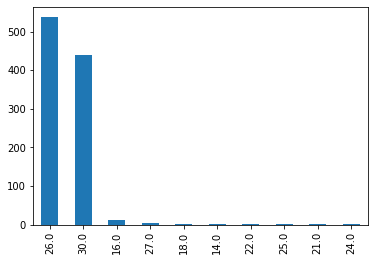

In [104]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.place_rank.value_counts().plot.bar()

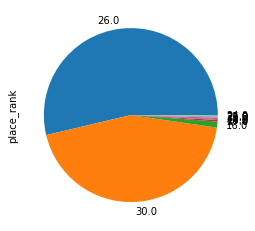

In [105]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.place_rank.value_counts().plot.pie()

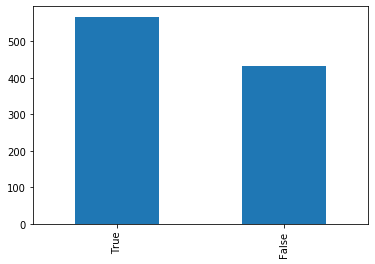

In [106]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.addr_out_number.isnull().value_counts().plot.bar()

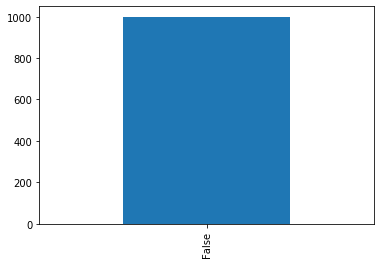

In [107]:
if AddressCleanserUtils.within_jupyter:
    addresses[config_module.housenbr_field].isnull().value_counts().plot.bar()

In [108]:
# Remark : only works when dask is not used 
# Gives times used of transformer, querying & processing osm, and checking results
if not with_dask:
    ts = AddressCleanserUtils.timestats
    tot = np.sum([ts[key] for key in ts])
    for key in ts: 
        log(f"{key:12}: {ts[key]} ({100*ts[key]/tot:.3} %)")

# Output

In [109]:
output_folder = address_file.rsplit(".", 1)[0]

import os

try:
    os.mkdir(output_folder)
except OSError:
    log ("Creation of the directory %s failed" % output_folder)
else:
    log ("Successfully created the directory %s " % output_folder)
    
    
output_filename_xls = output_folder + "/match.xlsx"
output_filename_pkl = output_folder + "/match.pkl"

nomatch_filename = output_folder + "/nomatch.xlsx"

reject_filename = output_folder + "/reject.xlsx"

stats_filename = output_folder + "/stats.xlsx"

[2020-04-24 06:24:38,765]  Successfully created the directory ./best.csv 


In [110]:
final_output = addresses.merge(osm_addresses, how="left")


log(f"Writing results on {output_filename_xls} ...")
try: 
    final_output.to_excel(output_filename_xls)
except Exception as e: 
    log("Failed ! ")
    log(e)
    
log(f"Writing results on {output_filename_pkl} ...")
try: 
    final_output.to_pickle(output_filename_pkl)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

[2020-04-24 06:24:38,803]  Writing results on ./best.csv/match.xlsx ...
[2020-04-24 06:24:40,846]  Writing results on ./best.csv/match.pkl ...


In [111]:
log(f"Writing rejected on {reject_filename} ...")
try: 

    rejected_addresses_final.sort_values([config_module.addr_key_field]).set_index([config_module.addr_key_field,
                                                                               config_module.street_field,
                                                                               config_module.housenbr_field,
                                                                               config_module.postcode_field,
                                                                               config_module.city_field,
                                                                               "method"]).to_excel(reject_filename)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

log(f"Writing nomatch on {nomatch_filename} ...")
try: 
    nomatch =  addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])]
    nomatch.to_excel(nomatch_filename)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

[2020-04-24 06:24:40,874]  Writing rejected on ./best.csv/reject.xlsx ...
[2020-04-24 06:24:40,903]  Failed ! 
[2020-04-24 06:24:40,905]  index 0 is out of bounds for axis 0 with size 0
[2020-04-24 06:24:40,907]  Writing nomatch on ./best.csv/nomatch.xlsx ...


In [129]:
log(f"Writing stats on {stats_filename} ...")
try: 
    with pd.ExcelWriter(stats_filename) as writer:
        _stats.to_excel(writer, "match_rate")
        
        pr_vc = osm_addresses.place_rank.value_counts()
        pr_vc = pd.concat([pr_vc, pr_vc/ osm_addresses.shape[0]], axis=1)
        pr_vc.columns = ["Count", "%"]
        pr_vc.to_excel(writer, "place_rank")

except Exception as e: 
    log("Failed ! ")
    log(e)
    

[2020-04-24 06:30:15,545]  Writing stats on ./best.csv/stats.xlsx ...


In [113]:
log("Done !")
log(f"Total time : {datetime.now() - starting_time}")

[2020-04-24 06:24:41,001]  Done !
[2020-04-24 06:24:41,003]  Total time : 0:01:55.572560
